In [1]:
import optuna
import numpy as np  
import optuna.visualization as vis
import os
import plotly
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import seaborn as sns



/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
        
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:, 1]
    
    data=(data) / np.max(data)  ### valor maximo
    # #data=(data - np.min(data)) / (np.max(data) - np.min(data)) ### min-max
    # data=(data - np.mean(data)) / np.std(data)
    
    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)


    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }


def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    # Inicialización de arrays para promedios de bandas
    main_welch=np.zeros(129)
    main_Delta = np.zeros(2)
    main_Theta = np.zeros(2)
    main_Alpha = np.zeros(2)
    main_Beta = np.zeros(2)
    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 


        data = np.loadtxt(nombre)
        data=(data) / np.max(data)  ### valor maximo
        # #data=(data - np.min(data)) / (np.max(data) - np.min(data)) ### min-max
        # data=(data - np.mean(data)) / np.std(data)
        Datos[i]=data

        Butter[i]=butter= signal.filtfilt(b, a,data)

        frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        main_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        main_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        main_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        main_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        main_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos,"buter":Butter, "frequencies": Frequencies,  "welch_data":welch_datos,"main_welch":main_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'main_Delta': main_Delta,'main_Theta':main_Theta,"main_Alpha":main_Alpha,"main_Beta":main_Beta
    }



### Análisis de todos los estudios con todo tipo de redes 

In [3]:
# Directorio donde están almacenados los estudios
study_directory = "Estudios/Full_red/bandas"  # Asegúrate de que este sea el directorio correcto

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)


number_top=200

# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos
best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:15]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Values:", trial.values)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")


Global Trial 1:
Study: 4bandas_full_max
Params: {'L': 30, 'P': 0.46066927633942717, 'Inh': 0.0027851139379593062, 'Trest': -4.3260858120163785, 'Trelative': 2.0760250719856796, 'C_h': 10.24828488135783, 'Tipo_red': 2}
Values: [9.500807056783442]
Sum of Values: 9.500807056783442
---------------------------------------
Global Trial 2:
Study: 4bandas_full_max
Params: {'L': 27, 'P': 0.6457124424651954, 'Inh': 0.541760495773707, 'Trest': -5.9892902820017655, 'Trelative': 3.479286594607822, 'C_h': 20.979440100329665, 'Tipo_red': 2}
Values: [10.182531676134104]
Sum of Values: 10.182531676134104
---------------------------------------
Global Trial 3:
Study: 4bandas_full_max
Params: {'L': 33, 'P': 0.44281389881087013, 'Inh': 0.31587101855111266, 'Trest': -4.671953721354463, 'Trelative': 2.601090482921603, 'C_h': 13.371330071609812, 'Tipo_red': 2}
Values: [11.175159795496445]
Sum of Values: 11.175159795496445
---------------------------------------
Global Trial 4:
Study: 4bandas_full_max
Params:


Frecuencia de aparición de cada estudio en los mejores 200 ensayos:
Estudio 4bandas_full_max: 161 veces
Estudio 4bandas_full_Z_score: 33 veces
Estudio 4bandas_full_min_max: 6 veces

Frecuencia de cada tipo de red en los mejores 200 ensayos:
Tipo de red 2: 160 veces
Tipo de red 1: 39 veces
Tipo de red 0: 1 veces

Media del tamaño L en los mejores 200 ensayos: 37.785


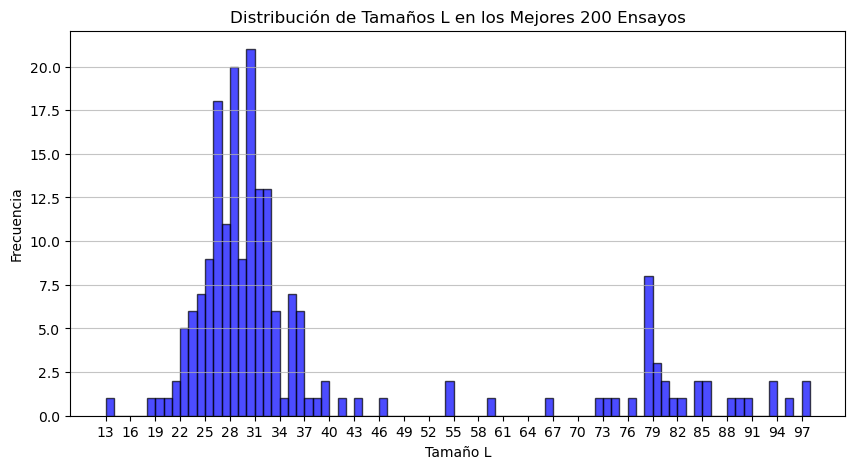

In [4]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L

# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)
size_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1

for size in sizes:
    size_frequency_count[size] += 1  # Contar la frecuencia de cada tamaño L

print(f"\nFrecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"\nFrecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")

mean_size = np.mean(sizes)
print(f"\nMedia del tamaño L en los mejores {number_top} ensayos: {mean_size}")

# Graficar la distribución de los tamaños L
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=range(min(sizes), max(sizes) + 1), alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Distribución de Tamaños L en los Mejores {number_top} Ensayos')
plt.xlabel('Tamaño L')
plt.ylabel('Frecuencia')
plt.xticks(range(min(sizes), max(sizes) + 1,3))
plt.grid(axis='y', alpha=0.75)
plt.show()

### Análisis de todos los estudios con red tipo Small world

In [6]:
# Directorio donde están almacenados los estudios
study_directory = "Estudios/small_world/bandas"  # Asegúrate de que este sea el directorio correcto

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)

# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos

number_top=200

best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:15]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Values:", trial.values)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")


Global Trial 1:
Study: 4bandas_SW_max
Params: {'L': 29, 'P': 0.3495855264639949, 'Inh': 0.4374925488997701, 'Trest': -5.413378622682971, 'Trelative': 4.30925916893512, 'C_h': 26.897198730686277, 'Tipo_red': 2}
Values: [8.597448821266049]
Sum of Values: 8.597448821266049
---------------------------------------
Global Trial 2:
Study: 4bandas_SW_max
Params: {'L': 23, 'P': 0.660500086275713, 'Inh': 0.405158763656728, 'Trest': -3.671349112221547, 'Trelative': 4.006004660878625, 'C_h': 30.21558499348253, 'Tipo_red': 2}
Values: [8.759115375528829]
Sum of Values: 8.759115375528829
---------------------------------------
Global Trial 3:
Study: 4bandas_SW_max
Params: {'L': 28, 'P': 0.4003607242088635, 'Inh': 0.38773594362596087, 'Trest': -4.777369412904715, 'Trelative': 3.109356702199154, 'C_h': 26.600001062564257, 'Tipo_red': 2}
Values: [9.157574261433833]
Sum of Values: 9.157574261433833
---------------------------------------
Global Trial 4:
Study: 4bandas_SW_max
Params: {'L': 25, 'P': 0.4148

### Análisis de todas las redes con chi2 y correcciones de la normalizacion 

In [7]:

# Directorio donde están almacenados los estudios
study_directory = "Estudios/Full_red/chi2"  # Asegúrate de que este sea el directorio correcto

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)

# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos

number_top=200

best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:15]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Values:", trial.values)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")


Global Trial 1:
Study: Chi30_full_zscore
Params: {'L': 31, 'P': 0.7112524572168807, 'Inh': 0.9851647656052183, 'Trest': 0.024940070810451492, 'Trelative': 4.768821432145168, 'C_h': 23.90956841701651, 'Tipo_red': 1}
Values: [0.6735684383325101]
Sum of Values: 0.6735684383325101
---------------------------------------
Global Trial 2:
Study: Chi30_full_zscore
Params: {'L': 35, 'P': 0.6366283466207243, 'Inh': 0.9478404540197866, 'Trest': 0.5069542818217241, 'Trelative': 4.047572612411822, 'C_h': 34.56853291051073, 'Tipo_red': 1}
Values: [0.7239311415097618]
Sum of Values: 0.7239311415097618
---------------------------------------
Global Trial 3:
Study: Chi30_full_zscore
Params: {'L': 36, 'P': 0.7515942919876798, 'Inh': 0.9823434169763867, 'Trest': 0.4778253608438614, 'Trelative': 4.3648841973798165, 'C_h': 9.068678007341294, 'Tipo_red': 1}
Values: [0.8154200033107102]
Sum of Values: 0.8154200033107102
---------------------------------------
Global Trial 4:
Study: Chi30_full_zscore
Params: 


Frecuencia de aparición de cada estudio en los mejores 200 ensayos:
Estudio Chi30_full_zscore: 177 veces
Estudio Chi30_full_min-max: 21 veces
Estudio Chi30_full_max: 2 veces

Frecuencia de cada tipo de red en los mejores 200 ensayos:
Tipo de red 1: 198 veces
Tipo de red 0: 2 veces

Media del tamaño L en los mejores 200 ensayos: 35.955


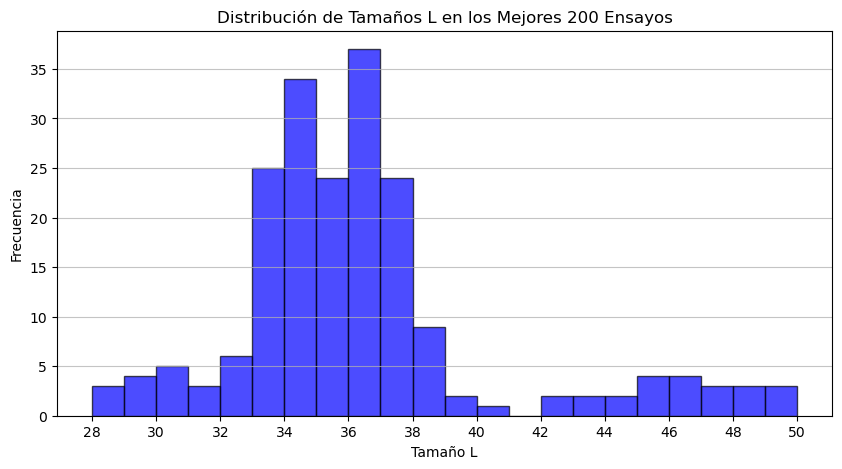

In [8]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L

# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)
size_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1

for size in sizes:
    size_frequency_count[size] += 1  # Contar la frecuencia de cada tamaño L

# Mostrar la frecuencia de aparición de cada estudio en los mejores 150 ensayos
print(f"\nFrecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"\nFrecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")

# # Mostrar la frecuencia de cada tamaño L en los mejores 150 ensayos
# print("\nFrecuencia de cada tamaño L en los mejores 150 ensayos:")
# for size, count in size_frequency_count.items():
#     print(f"Tamaño L {size}: {count} veces")

mean_size = np.mean(sizes)
print(f"\nMedia del tamaño L en los mejores {number_top} ensayos: {mean_size}")

# Graficar la distribución de los tamaños L
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=range(min(sizes), max(sizes) + 1), alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Distribución de Tamaños L en los Mejores {number_top} Ensayos')
plt.xlabel('Tamaño L')
plt.ylabel('Frecuencia')
plt.xticks(range(min(sizes), max(sizes) + 1,2))
plt.grid(axis='y', alpha=0.75)
plt.show()

### Análisis de todos los estudios con small_wold normalizacion max y chi_squere

In [13]:
# Directorio donde están almacenados los estudios
study_directory = "Estudios/small_world/chi2"  # Asegúrate de que este sea el directorio correcto

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name=="4bandas_SW_max_chi30_TR.db":
        continue

    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)

# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos

number_top=100

best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:15]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Values:", trial.values)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")


Global Trial 1:
Study: 4bandas_SW_max_chi30
Params: {'L': 24, 'P': 0.976656261077567, 'Inh': 0.018217167498983177, 'Trest': -3.887767671371372, 'Trelative': 1.2054348906695989, 'C_h': 8.10720457892007, 'Tipo_red': 2}
Values: [1.0480707721868963]
Sum of Values: 1.0480707721868963
---------------------------------------
Global Trial 2:
Study: 4bandas_SW_max_chi30
Params: {'L': 28, 'P': 0.9253468363464863, 'Inh': 0.0361049437419385, 'Trest': -5.5290696962103025, 'Trelative': 1.827347734282308, 'C_h': 9.841897807423496, 'Tipo_red': 2}
Values: [1.4987201459025161]
Sum of Values: 1.4987201459025161
---------------------------------------
Global Trial 3:
Study: 4bandas_SW_max_chi30
Params: {'L': 24, 'P': 0.5249987038302878, 'Inh': 0.03734776997096831, 'Trest': -7.774568024676133, 'Trelative': 1.9978475992176503, 'C_h': 14.502573832916028, 'Tipo_red': 2}
Values: [1.576728896579596]
Sum of Values: 1.576728896579596
---------------------------------------
Global Trial 4:
Study: 4bandas_SW_max_ch

In [14]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L
trest_values = [trial.params['Trest'] for trial in best_trials_global]  # Recopilar Trest
trela_values = [trial.params['Trelative'] for trial in best_trials_global]  # Recopilar Trest
Chiper=[trial.params['C_h'] for trial in best_trials_global]  # Recopilar Trest

P_values = [trial.params['P'] for trial in best_trials_global]  # Recopilar P
Inh_values = [trial.params['Inh'] for trial in best_trials_global]  # Recopilar P
# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1


# Mostrar la frecuencia de aparición de cada estudio en los mejores 150 ensayos
print(f"\nFrecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"\nFrecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")




Frecuencia de aparición de cada estudio en los mejores 100 ensayos:
Estudio 4bandas_SW_max_chi30: 83 veces
Estudio 4bandas_SW_max_chi60: 17 veces

Frecuencia de cada tipo de red en los mejores 100 ensayos:
Tipo de red 2: 83 veces
Tipo de red 1: 17 veces


In [11]:
print(f"\nMedia del L: {np.mean(sizes)}")
print(f"Desviación estándar del L: {np.std(sizes)}")
print(f"Mediana del L: { np.median(sizes)}")
print(f"Primer cuartil (Q1) del L: {np.percentile(sizes, 25)}")
print(f"Tercer cuartil (Q3) del L: {np.percentile(sizes, 75)}")


print(f"\nMedia del Trest: {np.mean(trest_values)}")
print(f"Desviación estándar del Trest: {np.std(trest_values)}")
print(f"Mediana del Trest: {np.median(trest_values)}")
print(f"Primer cuartil (Q1) del Trest: {np.percentile(trest_values, 25)}")
print(f"Tercer cuartil (Q3) del Trest: {np.percentile(trest_values, 75)}")

print(f"\nMedia del Trela: {np.mean(trela_values)}")
print(f"Desviación estándar del Trela: {np.std(trela_values)}")
print(f"Mediana del Trela: {np.median(trela_values)}")
print(f"Primer cuartil (Q1) del Trela: {np.percentile(trela_values, 25)}")
print(f"Tercer cuartil (Q3) del Trela: {np.percentile(trela_values, 75)}")

print(f"\nMedia del P: {np.mean(P_values)}")
print(f"Desviación estándar del P: {np.std(P_values)}")
print(f"Mediana del P: { np.median(P_values)}")
print(f"Primer cuartil (Q1) del P: {np.percentile(P_values, 25)}")
print(f"Tercer cuartil (Q3) del P: {np.percentile(P_values, 75)}")

print(f"\nMedia del Inh: {np.mean(Inh_values)}")
print(f"Desviación estándar del Inh: {np.std(Inh_values)}")
print(f"Mediana del Inh: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del Inh: {np.percentile(Inh_values, 25)}")
print(f"Tercer cuartil (Q3) del Inh: {np.percentile(Inh_values, 75)}")

print(f"\nMedia del C hiper: {np.mean(Chiper)}")
print(f"Desviación estándar del C hiper: {np.std(Chiper)}")
print(f"Mediana del C hiper: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del C hiper: {np.percentile(Chiper, 25)}")
print(f"Tercer cuartil (Q3) del C hiperh: {np.percentile(Chiper, 75)}")


Media del L: 28.54
Desviación estándar del L: 5.958892514553354
Mediana del L: 27.0
Primer cuartil (Q1) del L: 25.0
Tercer cuartil (Q3) del L: 31.0

Media del Trest: -4.510111485122016
Desviación estándar del Trest: 1.718709789173793
Mediana del Trest: -4.73957246072081
Primer cuartil (Q1) del Trest: -5.476471955431965
Tercer cuartil (Q3) del Trest: -3.7006179397531733

Media del Trela: 2.4796226652428244
Desviación estándar del Trela: 1.1323443085707507
Mediana del Trela: 2.0043814234821387
Primer cuartil (Q1) del Trela: 1.662403695765807
Tercer cuartil (Q3) del Trela: 3.1596329817490023

Media del P: 0.7989075390950107
Desviación estándar del P: 0.1795861210322387
Mediana del P: 0.8688334452165506
Primer cuartil (Q1) del P: 0.7134778836931308
Tercer cuartil (Q3) del P: 0.9301132804329225

Media del Inh: 0.1687155713779518
Desviación estándar del Inh: 0.17018362873548395
Mediana del Inh: 0.07890639585927606
Primer cuartil (Q1) del Inh: 0.047095751002754094
Tercer cuartil (Q3) del Inh

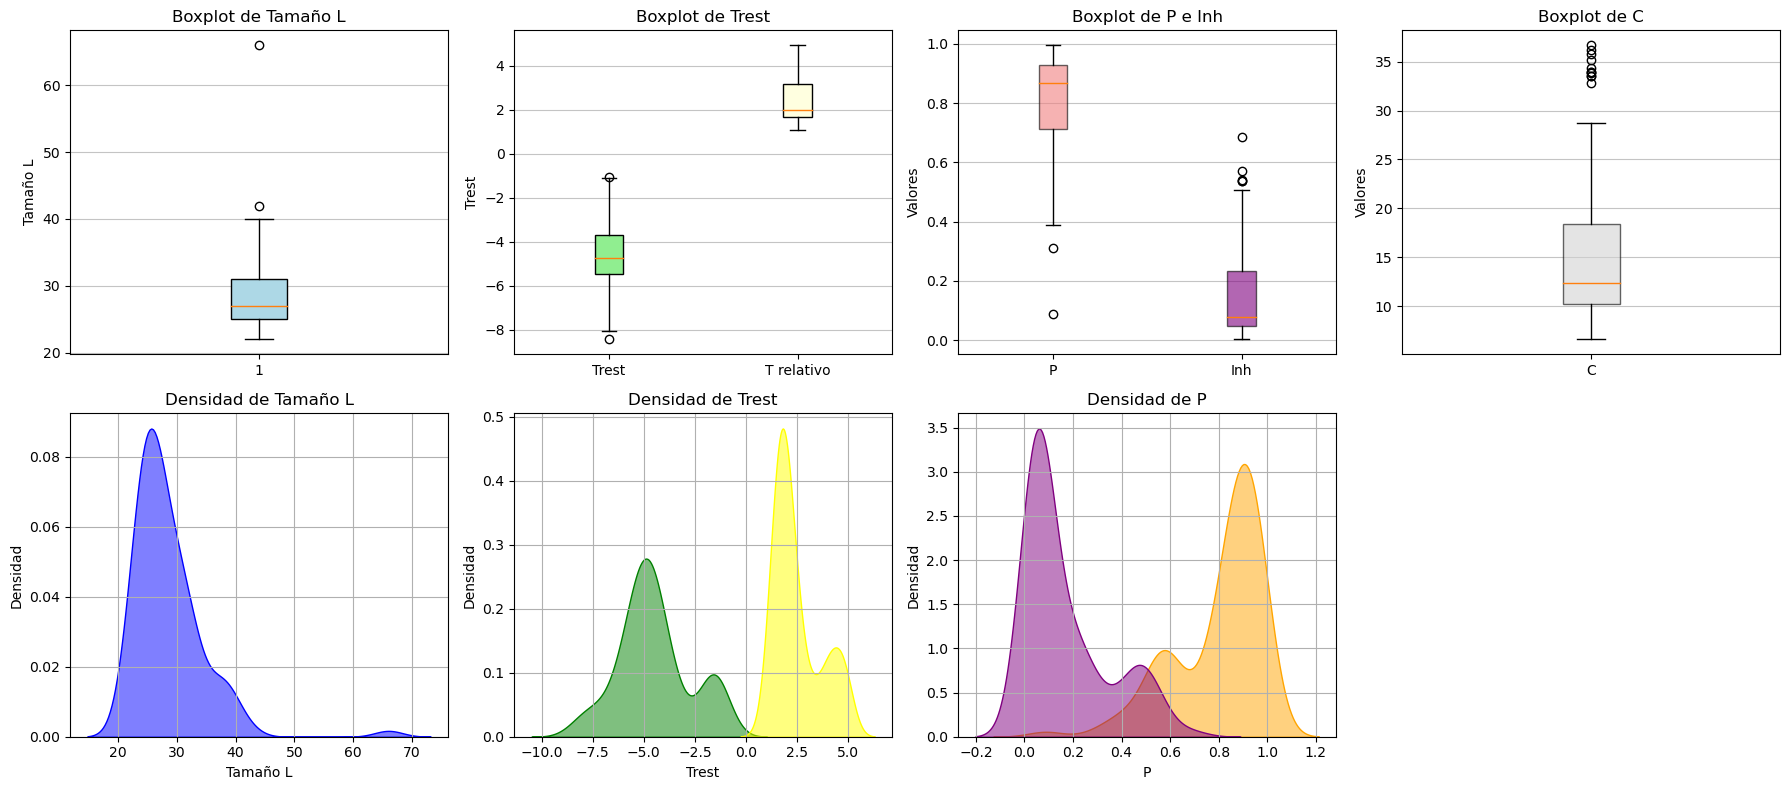

In [12]:
plt.figure(figsize=(18, 8))

# Boxplot de Tamaño L
plt.subplot(2, 4, 1)
plt.boxplot(sizes, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Tamaño L')
plt.ylabel('Tamaño L')
plt.grid(axis='y', alpha=0.75)

# Boxplot de Trest
plt.subplot(2, 4, 2)
plt.boxplot(trest_values, patch_artist=True, boxprops=dict(facecolor='lightgreen'),labels=["Trest"])
plt.boxplot(trela_values, patch_artist=True, boxprops=dict(facecolor='lightyellow'),positions=[2],labels=['T relativo'])
plt.title('Boxplot de Trest')
plt.ylabel('Trest')
plt.grid(axis='y', alpha=0.75)

# Boxplot de P
plt.subplot(2, 4, 3)
plt.boxplot(P_values, patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.6), labels=['P'])  # Asignar etiqueta para P
plt.boxplot(Inh_values, patch_artist=True, boxprops=dict(facecolor='purple', alpha=0.6), positions=[2])  # Asignar etiqueta para Inh, en posición 2
plt.title('Boxplot de P e Inh')
plt.ylabel('Valores')
plt.xticks([1, 2], ['P', 'Inh'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 4, 4)
plt.boxplot(Chiper, patch_artist=True, boxprops=dict(facecolor='lightgrey', alpha=0.6), labels=['C'])  # Asignar etiqueta para P
plt.title('Boxplot de C')
plt.ylabel('Valores')
plt.xticks([1], ['C'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)


plt.subplot(2, 4, 5)
sns.kdeplot(sizes, fill=True, color='blue', alpha=0.5)
plt.title('Densidad de Tamaño L')
plt.xlabel('Tamaño L')
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para Trest
plt.subplot(2, 4, 6)
sns.kdeplot(trest_values, fill=True, color='green', alpha=0.5)
sns.kdeplot(trela_values, fill=True, color='yellow', alpha=0.5)
plt.title('Densidad de Trest')
plt.xlabel('Trest')
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para P
plt.subplot(2, 4, 7)
sns.kdeplot(P_values, fill=True, color='orange', alpha=0.5)
sns.kdeplot(Inh_values, fill=True, color='purple', alpha=0.5)
plt.title('Densidad de P')
plt.xlabel('P')
plt.ylabel('Densidad')
plt.grid()

plt.tight_layout()
plt.show()


# Comparaciones 

In [18]:
Params1={'L': 29, 'P': 0.3495855264639949, 'Inh': 0.4374925488997701, 'Trest': -5.413378622682971, 'Trelative': 4.30925916893512, 'C_h': 26.897198730686277, 'Tipo_red': 2}
Params2={'L': 26, 'P': 0.33981932023962347, 'Inh': 0.02107991586244312, 'Trest': -3.4986968261684956, 'Trelative': 5.046911268168111, 'C_h': 36.96411970962938, 'Tipo_red': 1}
Params3={'L': 24, 'P': 0.976656261077567, 'Inh': 0.018217167498983177, 'Trest': -3.887767671371372, 'Trelative': 1.2054348906695989, 'C_h': 8.10720457892007, 'Tipo_red': 2}
Params4={'L': 34, 'P': 0.5788993606887883, 'Inh': 0.48736371326785494, 'Trest': -1.8947598510427208, 'Trelative': 4.6820098908331165, 'C_h': 35.17056543528971, 'Tipo_red': 1}

initial_params1 = [Params1["L"], Params1["P"],Params1["Inh"], Params1["Trest"],Params1["Trelative"], Params1["C_h"] ,8030, Params1["Tipo_red"]]
initial_params2 = [Params2["L"], Params2["P"],Params2["Inh"], Params2["Trest"],Params2["Trelative"], Params2["C_h"] ,8030, Params2["Tipo_red"]]
initial_params3 = [Params3["L"], Params3["P"],Params3["Inh"], Params3["Trest"],Params3["Trelative"], Params3["C_h"] ,8030, Params3["Tipo_red"]]
initial_params4 = [Params4["L"], Params4["P"],Params4["Inh"], Params4["Trest"],Params4["Trelative"], Params4["C_h"] ,8030, Params4["Tipo_red"]]


generated_data1 = Simulado_EGG(initial_params1)
generated_data2 = Simulado_EGG(initial_params2)
generated_data3 = Simulado_EGG(initial_params3)
generated_data4 = Simulado_EGG(initial_params4)


reales_total_P = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])


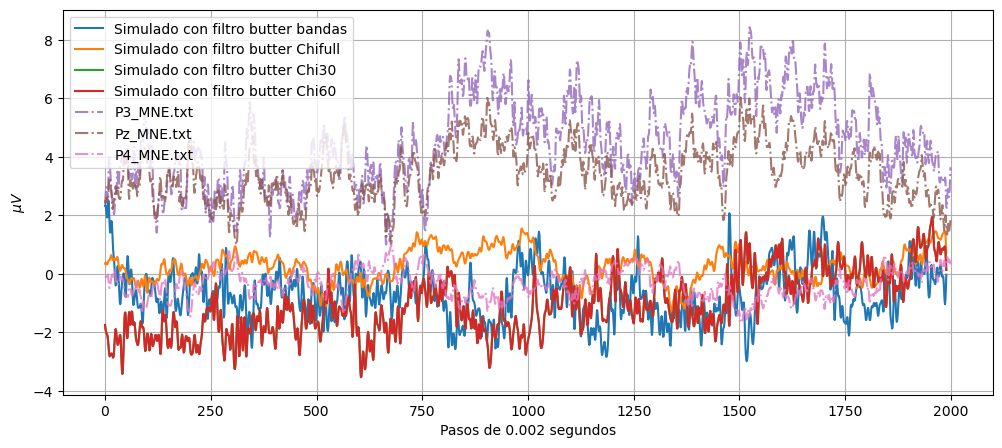

In [19]:
fig, ax = plt.subplots(figsize=[12, 5])

#ax.plot(generated_data1["data_resample"],label="Simulado")
ax.plot(generated_data1["butter"][10:],label="Simulado con filtro butter bandas")
ax.plot(generated_data2["butter"][10:],label="Simulado con filtro butter Chifull")
ax.plot(generated_data3["butter"][10:],label="Simulado con filtro butter Chi30")
ax.plot(generated_data3["butter"][10:],label="Simulado con filtro butter Chi60")



for i in range(3):
    ax.plot(reales_total_P["datos"][i],"-.", label=reales_total_P["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


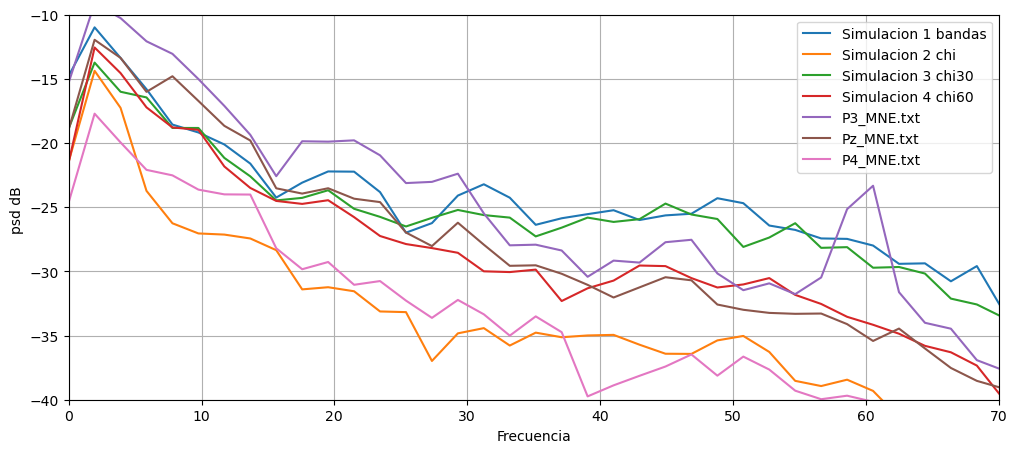

In [24]:
fig, ax = plt.subplots(figsize=[12, 5])


ax.plot(generated_data1["frequencies"],generated_data1["welch_data"],label="Simulacion 1 bandas")
ax.plot(generated_data2["frequencies"],generated_data2["welch_data"],label="Simulacion 2 chi")
ax.plot(generated_data3["frequencies"],generated_data3["welch_data"],label="Simulacion 3 chi30")
ax.plot(generated_data4["frequencies"],generated_data4["welch_data"],label="Simulacion 4 chi60 ")

# ax.plot(reales_total_P["frequencies"][0],reales_total_P["mean_welch"],linestyle="-.",label="mean welch")

for i in range(3):
    ax.plot(reales_total_P["frequencies"][i],reales_total_P["welch_data"][i], label=reales_total_P["Nombres"][i])

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.xlim(0,70)
plt.ylim(-40,-10)
plt.grid()
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [16]:
import optuna
import optuna.visualization as vis
import matplotlib.pyplot as plt
# Directorio donde están almacenados los estudios
study_directory = "Estudios/small_world/chi2/"  # Ajusta según sea necesario
study_name = "4bandas_SW_max_chi30"  # Cambia al nombre de tu estudio
# Cargar el estudio
study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_directory}{study_name}.db")


In [17]:
# Gráfico de correlación entre los parámetros y los objetivos
vis.plot_param_importances(study)


In [18]:
# Gráfico de slice para explorar la relación entre los parámetros y los objetivos
%matplotlib inline
vis.plot_slice(study)


In [19]:
# Gráfico de coordenadas paralelas para visualizar múltiples objetivos
%matplotlib inline
vis.plot_parallel_coordinate(study)
